In [4]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, Point
import json
import matplotlib.pyplot as plt
import requests
import plotly.express as px
import io
from PIL import Image
import zipfile
import rasterio
from rasterio.io import MemoryFile
import requests
from io import BytesIO
from rasterio.features import geometry_mask
import rasterio
from rasterio.plot import show
from shapely.geometry import mapping
import numpy as np
import matplotlib.cm as cm
import requests
import folium
from matplotlib.colors import LogNorm
import networkx as nx
import osmnx as ox
from rasterio.plot import show
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import ee
import geopandas as gpd
import pandas as pd
from h3 import h3
from tobler.util import h3fy
from tobler.area_weighted import area_interpolate
import matplotlib.pyplot as plt
import contextily as cx
from shapely import wkt
import matplotlib.patches as mpatches
import warnings
import geopandas
import pandas
import rioxarray
import rasterio
import xarray
import fsspec
import os
import h3
from shapely.geometry import shape, mapping
from shapely.ops import cascaded_union
warnings.filterwarnings('ignore')
%matplotlib inline

In [7]:
bay_area_county_data = pd.read_csv('Bay_Area_County_Polygons_20240416.csv')
counties_of_interest = ['San Mateo', 'San Francisco', 'Marin', 'Alameda', 'Contra Costa']
bay_area_county_data = bay_area_county_data[bay_area_county_data['COUNTY'].isin(counties_of_interest)]
bay_area_county_data['geometry'] = bay_area_county_data['the_geom'].apply(wkt.loads)
bay_area_county_data = gpd.GeoDataFrame(bay_area_county_data, geometry='geometry', crs='EPSG:4326').drop(columns=['the_geom', 'OBJECTID'])
hexes = h3fy(bay_area_county_data.to_crs('epsg:4326'), resolution=8, clip=True).to_crs("epsg:26910")

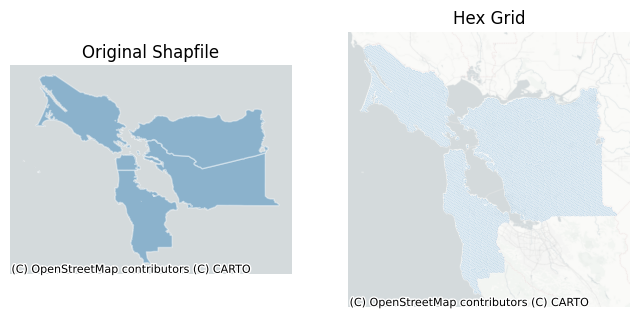

In [8]:
fig, axs = plt.subplots(1,2, figsize=(8,8))
axs=axs.flatten()

bay_area_county_data.plot(ax=axs[0], alpha=0.4, linewidth=1, edgecolor='white')
hexes.plot(ax=axs[1], alpha=0.4, linewidth=1, edgecolor='white')

axs[0].set_title('Original Shapfile')
axs[1].set_title('Hex Grid')

for i,_ in enumerate(axs):
    cx.add_basemap(
        axs[i],
        crs=hexes.crs.to_string(),
        source=cx.providers.CartoDB.PositronNoLabels)
    axs[i].axis('off')

Google Earth Engine

In [10]:
ee.Authenticate()
ee.Initialize(project='ee-zeyuwu2001')

# Define the MODIS dataset and filter by date
dataset = ee.ImageCollection('MODIS/061/MOD11A1') \
    .filter(ee.Filter.date('2023-03-01', '2023-05-31'))

# Select the land surface temperature band
landSurfaceTemperature = dataset.select('LST_Day_1km')

# Define the visualization parameters
landSurfaceTemperatureVis = {
    'min': 14000.0,
    'max': 16000.0,
    'palette': [
        '040274', '040281', '0502a3', '0502b8', '0502ce', '0502e6',
        '0602ff', '235cb1', '307ef3', '269db1', '30c8e2', '32d3ef',
        '3be285', '3ff38f', '86e26f', '3ae237', 'b5e22e', 'd6e21f',
        'fff705', 'ffd611', 'ffb613', 'ff8b13', 'ff6e08', 'ff500d',
        'ff0000', 'de0101', 'c21301', 'a71001', '911003'
    ]
}

# Set the center of the map
center_coords = [46.529, 6.746]
zoom_level = 2

# Create a folium map centered on the specified coordinates and zoom level
map_center = folium.Map(location=center_coords[::-1], zoom_start=zoom_level)

# Add the land surface temperature layer to the map
map_id_dict = ee.Image(landSurfaceTemperature.first()).getMapId(landSurfaceTemperatureVis)
folium.TileLayer(
    tiles=map_id_dict['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name='Land Surface Temperature',
    overlay=True,
    control=True
).add_to(map_center)

# Display the map
display(map_center)

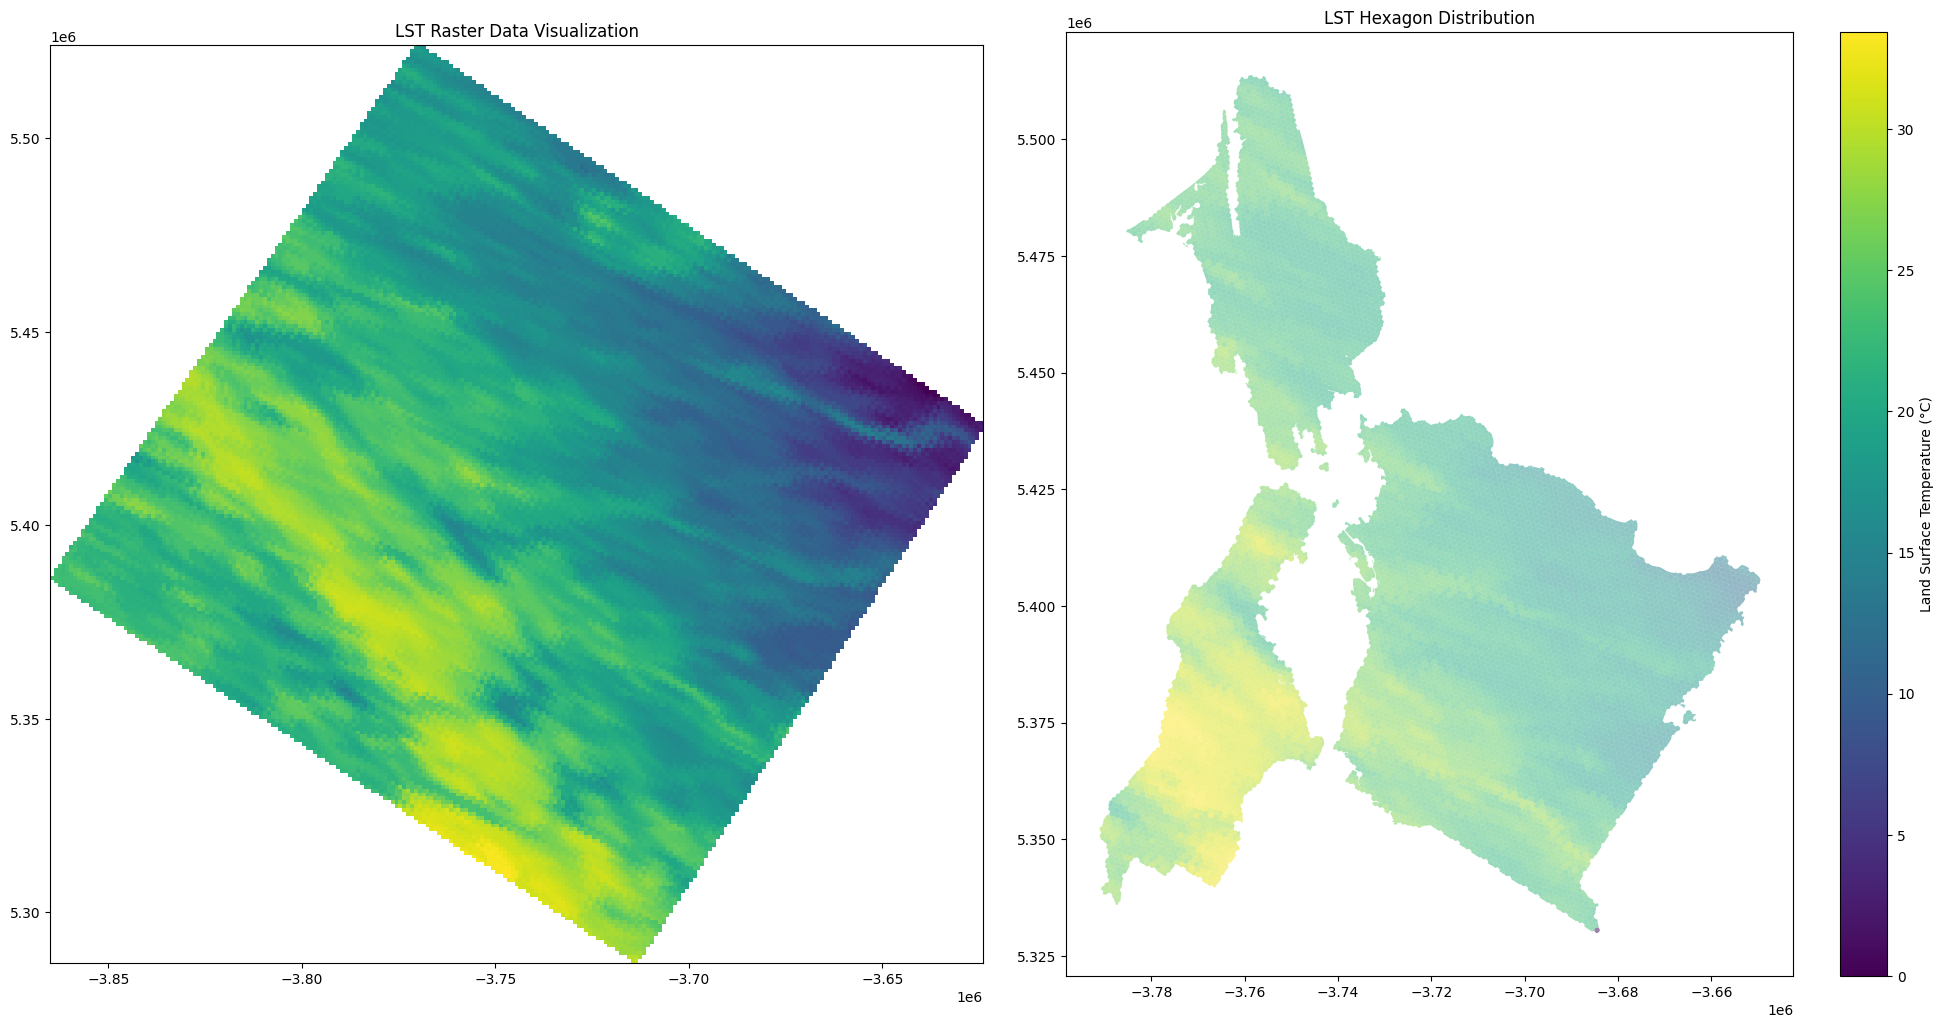

'\nresponse = requests.get(url)\nif response.status_code == 200:\n    with MemoryFile(response.content) as memfile:\n        with memfile.open() as dataset:\n            # Load and align CRS for hexagon vector data\n            hexagons = hexes\n            hexagons = hexagons.to_crs(dataset.crs)\n\n            # Sample LST values at hexagon centroids using the corrected method\n            hexagons[\'centroid\'] = hexagons.geometry.centroid\n            hexagons[\'lst_value\'] = hexagons[\'centroid\'].apply(\n                lambda point: next(dataset.sample([(point.x, point.y)]))[0]\n            )\n\n            # Plotting the raster data\n            plt.figure(figsize=(10, 10))\n            show(dataset, cmap=\'viridis\', title=\'LST Raster Data Visualization\')\n            plt.show()\n\n            # Plotting the hexagons with LST values\n            fig, ax = plt.subplots(figsize=(10, 10))\n            hexagons.plot(ax=ax, column=\'lst_value\', alpha=0.5, legend=True,\n         

In [32]:
ee.Authenticate()
ee.Initialize(project='ee-zeyuwu2001')

# Define the area of interest
nyc_bounds = ee.Geometry.Rectangle(list(bay_area_county_data.total_bounds))

# Access MODIS LST data for daytime temperatures during Spring 2023
lst_data = ee.ImageCollection('MODIS/061/MOD11A1') \
    .filterDate('2023-01-01', '2023-12-31') \
    .filterBounds(nyc_bounds) \
    .select('LST_Day_1km') \
    .mean() \
    .multiply(0.02) \
    .subtract(273.15)  # Convert to Celsius

# Clip the data to the bounds of NYC and adjust the scale
scale = 1000  # Increased scale to reduce image resolution and size
lst_clipped = lst_data.clip(nyc_bounds)

# Generate a download URL for the clipped image at a reduced scale
url = lst_clipped.getDownloadURL({
    'scale': scale,
    'crs': 'EPSG:32618',
    'format': 'GeoTIFF'
})

# Download the image using requests
response = requests.get(url)  # Assuming 'url' is already defined as shown in your previous code
if response.status_code == 200:
    with MemoryFile(response.content) as memfile:
        with memfile.open() as dataset:
            # Load and align CRS for hexagon vector data
            hexagons = hexes  # Assuming 'hexes' is a GeoDataFrame you've previously defined
            hexagons = hexagons.to_crs(dataset.crs)

            # Sample LST values at hexagon centroids
            hexagons['centroid'] = hexagons.geometry.centroid
            hexagons['lst_value'] = hexagons['centroid'].apply(
                lambda point: next(dataset.sample([(point.x, point.y)]))[0]
            )

            # Create a figure and a set of subplots
            fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))  # Two plots in one row

            # Plotting the raster data
            ax1 = axs[0]  # First subplot
            show(dataset, ax=ax1, cmap='viridis', title='LST Raster Data')
            ax1.set_title('LST Raster Data Visualization')

            # Plotting the hexagons with LST values
            ax2 = axs[1]  # Second subplot
            hexagons.plot(ax=ax2, column='lst_value', alpha=0.5, legend=True,
                          legend_kwds={'label': "Land Surface Temperature (°C)"})
            ax2.set_title('LST Hexagon Distribution')

            plt.tight_layout()  # Adjust layout to fit both plots
            plt.show()

else:
    print("Failed to download data:", response.status_code)
'''
response = requests.get(url)
if response.status_code == 200:
    with MemoryFile(response.content) as memfile:
        with memfile.open() as dataset:
            # Load and align CRS for hexagon vector data
            hexagons = hexes
            hexagons = hexagons.to_crs(dataset.crs)

            # Sample LST values at hexagon centroids using the corrected method
            hexagons['centroid'] = hexagons.geometry.centroid
            hexagons['lst_value'] = hexagons['centroid'].apply(
                lambda point: next(dataset.sample([(point.x, point.y)]))[0]
            )

            # Plotting the raster data
            plt.figure(figsize=(10, 10))
            show(dataset, cmap='viridis', title='LST Raster Data Visualization')
            plt.show()

            # Plotting the hexagons with LST values
            fig, ax = plt.subplots(figsize=(10, 10))
            hexagons.plot(ax=ax, column='lst_value', alpha=0.5, legend=True,
                          legend_kwds={'label': "Land Surface Temperature (°C)"})
            plt.title('Hexagon LST Distribution')
            plt.show()

else:
    print("Failed to download data:", response.status_code)
'''

In [33]:
hexagons.head()

,geometry,centroid,lst_value
hex_id,,,
8828340515fffff,"POLYGON ((-3777799.208 5343115.557, -3777124.8...",POINT (-3777290.316 5342700.682),27.542368
882834053bfffff,"POLYGON ((-3776673.378 5342765.867, -3777124.8...",POINT (-3776450.903 5343392.331),27.816410
8828340533fffff,"POLYGON ((-3775776.369 5343530.281, -3776227.8...",POINT (-3775648.913 5344208.933),26.692583
88283405e5fffff,"POLYGON ((-3776456.398 5345132.193, -3776233.5...",POINT (-3775782.191 5345270.289),26.205785
8828340ed9fffff,"POLYGON ((-3775330.811 5344782.411, -3775108.0...",POINT (-3774646.386 5344979.638),28.714915


In [34]:
hexagons.shape

(8505, 3)

In [35]:
hexagons.lst_value.nunique()

4025